## siamese network

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import pickle

In [2]:
target_shape = (400,400)

In [3]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

In [4]:
def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [5]:
anchor_images_path = "original_sg"
positive_images_path = "snoise07_sg"

In [6]:
anchor_images = [str(anchor_images_path+'/'+f) for f in os.listdir(anchor_images_path)][0:1000]
positive_images = [str(positive_images_path+'/'+f) for f in os.listdir(positive_images_path)][0:1000]

In [7]:
anchor_images

['original_sg/s_1922.jpg',
 'original_sg/s_943.jpg',
 'original_sg/s_5090.jpg',
 'original_sg/s_5864.jpg',
 'original_sg/s_5708.jpg',
 'original_sg/s_2751.jpg',
 'original_sg/s_3373.jpg',
 'original_sg/s_375.jpg',
 'original_sg/s_3165.jpg',
 'original_sg/s_3509.jpg',
 'original_sg/s_2388.jpg',
 'original_sg/s_3074.jpg',
 'original_sg/s_2408.jpg',
 'original_sg/s_3310.jpg',
 'original_sg/s_5946.jpg',
 'original_sg/s_1731.jpg',
 'original_sg/s_6423.jpg',
 'original_sg/s_1192.jpg',
 'original_sg/s_4343.jpg',
 'original_sg/s_4649.jpg',
 'original_sg/s_2327.jpg',
 'original_sg/s_4609.jpg',
 'original_sg/s_6032.jpg',
 'original_sg/s_4267.jpg',
 'original_sg/s_2590.jpg',
 'original_sg/s_4034.jpg',
 'original_sg/s_5522.jpg',
 'original_sg/s_1323.jpg',
 'original_sg/s_6405.jpg',
 'original_sg/s_2766.jpg',
 'original_sg/s_6249.jpg',
 'original_sg/s_753.jpg',
 'original_sg/s_5764.jpg',
 'original_sg/s_379.jpg',
 'original_sg/s_3873.jpg',
 'original_sg/s_704.jpg',
 'original_sg/s_2019.jpg',
 'orig

In [8]:
positive_images

['snoise07_sg/s_1922.jpg',
 'snoise07_sg/s_943.jpg',
 'snoise07_sg/s_5090.jpg',
 'snoise07_sg/s_5864.jpg',
 'snoise07_sg/s_5708.jpg',
 'snoise07_sg/s_2751.jpg',
 'snoise07_sg/s_3373.jpg',
 'snoise07_sg/s_375.jpg',
 'snoise07_sg/s_3165.jpg',
 'snoise07_sg/s_3509.jpg',
 'snoise07_sg/s_2388.jpg',
 'snoise07_sg/s_3074.jpg',
 'snoise07_sg/s_2408.jpg',
 'snoise07_sg/s_3310.jpg',
 'snoise07_sg/s_5946.jpg',
 'snoise07_sg/s_1731.jpg',
 'snoise07_sg/s_6423.jpg',
 'snoise07_sg/s_1192.jpg',
 'snoise07_sg/s_4343.jpg',
 'snoise07_sg/s_4649.jpg',
 'snoise07_sg/s_2327.jpg',
 'snoise07_sg/s_4609.jpg',
 'snoise07_sg/s_6032.jpg',
 'snoise07_sg/s_4267.jpg',
 'snoise07_sg/s_2590.jpg',
 'snoise07_sg/s_4034.jpg',
 'snoise07_sg/s_5522.jpg',
 'snoise07_sg/s_1323.jpg',
 'snoise07_sg/s_6405.jpg',
 'snoise07_sg/s_2766.jpg',
 'snoise07_sg/s_6249.jpg',
 'snoise07_sg/s_753.jpg',
 'snoise07_sg/s_5764.jpg',
 'snoise07_sg/s_379.jpg',
 'snoise07_sg/s_3873.jpg',
 'snoise07_sg/s_704.jpg',
 'snoise07_sg/s_2019.jpg',
 'snoi

In [9]:
image_count = len(anchor_images)

# this will be changed to return a tf_dataset from Google Cloud
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

2022-11-30 09:32:36.074387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-30 09:32:36.074734: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-30 09:32:36.074792: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (matthias): /proc/driver/nvidia/version does not exist
2022-11-30 09:32:36.077471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


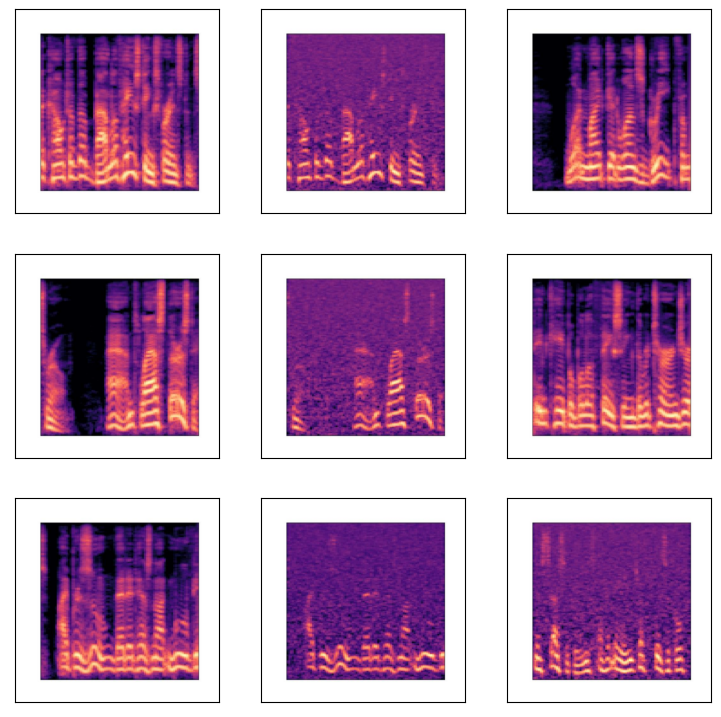

In [10]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [11]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

2022-11-30 09:34:02.895476: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 708837376 exceeds 10% of free system memory.
2022-11-30 09:34:03.696028: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 708837376 exceeds 10% of free system memory.
2022-11-30 09:34:04.042502: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 708837376 exceeds 10% of free system memory.


In [12]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [145]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [15]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset,batch_size=128, epochs=3, validation_data=val_dataset)

Epoch 1/3
25/25 [==============================] - 687s 27s/step - loss: 0.3756 - val_loss: 0.0441
Epoch 2/3
25/25 [==============================] - 652s 26s/step - loss: 0.0358 - val_loss: 0.0284
Epoch 3/3
25/25 [==============================] - 606s 24s/step - loss: 0.0301 - val_loss: 0.0506


In [83]:
anchor_embedding

<tf.Tensor: shape=(32, 256), dtype=float32, numpy=
array([[-4.7304583 ,  2.1117659 , -0.95630276, ...,  0.63446003,
        -1.6469649 , -4.774048  ],
       [-4.730207  ,  2.2766237 , -1.0818578 , ...,  0.569985  ,
        -1.162458  , -5.303293  ],
       [-4.5919533 ,  1.9264463 , -1.3347636 , ...,  0.69162065,
        -0.97840047, -5.1659207 ],
       ...,
       [-4.9576607 ,  2.3403313 , -0.9587809 , ...,  0.5813623 ,
        -1.4751911 , -4.980415  ],
       [-4.7083    ,  2.250842  , -1.0840541 , ...,  0.77255684,
        -0.78942645, -5.2171965 ],
       [-4.747727  ,  2.0046382 , -1.2599417 , ...,  0.5774835 ,
        -1.6271721 , -5.1475043 ]], dtype=float32)>

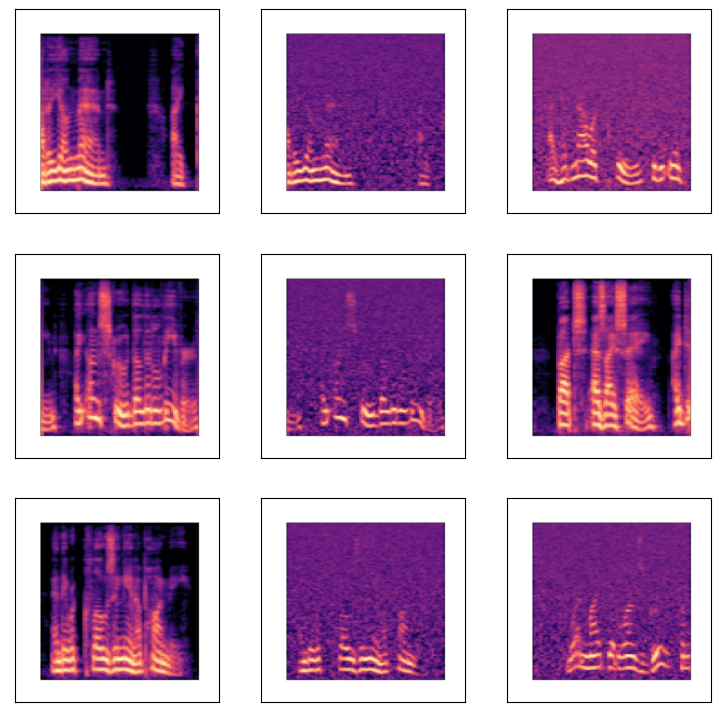

In [77]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [17]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9998894
Negative similarity 0.99949193


### Saving the model

In [62]:
siamese_model.history.model.weights

[<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
 array([[[[ 2.82526277e-02, -1.18737184e-02,  1.51488732e-03, ...,
           -1.07003953e-02, -5.27982824e-02, -1.36667420e-03],
          [ 5.86827798e-03,  5.04415408e-02,  3.46324709e-03, ...,
            1.01423981e-02,  1.39493728e-02,  1.67549420e-02],
          [-2.44090753e-03, -4.86173332e-02,  2.69966386e-03, ...,
           -3.44439060e-04,  3.48098315e-02,  6.28910400e-03]],
 
         [[ 1.81872323e-02, -7.20698107e-03,  4.80302610e-03, ...,
           -7.43396254e-03, -8.56800564e-03,  1.16849300e-02],
          [ 1.87554304e-02,  5.12730293e-02,  4.50406177e-03, ...,
            1.39413681e-02,  1.26296384e-02, -1.73004344e-02],
          [ 1.90453827e-02, -3.87909152e-02,  4.25842637e-03, ...,
            2.75742816e-04, -1.27962548e-02, -8.35626759e-03]],
 
         [[ 1.58849321e-02, -1.06073255e-02,  1.30999666e-02, ...,
           -2.26797583e-03, -3.98984266e-04,  3.39989027e-04],
      

### saving locally

as_numpy_iterator creates numpy array object need to convert them back to tensors, original function for preprocessing doesnt need converting as its already converted to a tensor at preprocessing

In [71]:
im1 = train_dataset.as_numpy_iterator().__next__()

In [93]:
pred_im1 = siamese_model.predict(im1)

1/1 [==============================] - 22s 22s/step


#### this is important, tis how we can actually supply imagess for the predict

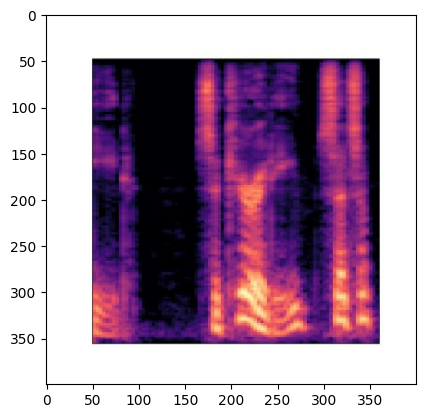

In [133]:

images_comp = preprocess_image("snoise_sg/s_0.jpg"), preprocess_image("snoise07_sg/s_0.jpg"), preprocess_image("snoise07_sg/s_1001.jpg")
plt.imshow(im1[0][0])

### reshaping and changng type of single image to fit the resnet embedding

In [134]:
images_comp[0].shape

TensorShape([400, 400, 3])

In [188]:
sample = next(iter(train_dataset))

anchor, positive, negative = images_comp
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(tf.expand_dims(anchor, 0))),
    embedding(resnet.preprocess_input(tf.expand_dims(positive, 0))),
    embedding(resnet.preprocess_input(tf.expand_dims(negative, 0))),
)

### converting it to tensor as the numpy iterator put them in a umpy array
# anchor, positive, negative = images_comp
# anchor_embedding, positive_embedding, negative_embedding = (
#     embedding(resnet.preprocess_input((anchor[0].(-1,400,400,3)))),
#     embedding(resnet.preprocess_input((positive[0].(-1,400,400,3)))),
#     embedding(resnet.preprocess_input((negative[0].(-1,400,400,3)))),
# )

In [189]:
cosine_similarity = tf.keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9999622
Negative similarity 0.9996795


### saving the model from weights

In [169]:
siamese_model.save_weights("s_weights.h5")
# do not try OPENING THE FILES!!! binary, loads of pop-ups and very annoying

## TO DO: how to move from load_weights to an actual model capable of doing cosine similarity

#### need to initialise an empty model and assign weights to it, not even compile just build it

In [165]:
model2

In [193]:
model2 = siamese_network
# model2.compile(optimizer=optimizers.Adam(0.0001))

# model3 = model2.load_weights("weights/s_test_model.h5")

In [194]:
model3 = SiameseModel(model2)

model3.compile(optimizer=optimizers.Adam(0.0001))

In [200]:
model3.build(input_shape =[(None, 400,400,3)]*3)

In [201]:
model3.load_weights("s_weights.h5")

In [192]:
siamese_model._compute_loss

<bound method SiameseModel._compute_loss of <__main__.SiameseModel object at 0x7f5fb826d2a0>>

In [186]:
model3._compute_loss

<bound method SiameseModel._compute_loss of <__main__.SiameseModel object at 0x7f5f924ed6c0>>

In [187]:
SiameseModel._compute_loss

<function __main__.SiameseModel._compute_loss(self, data)>

In [210]:
model3.summary()

Model: "siamese_model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          ((None,),                 200997760 
                              (None,))                           
                                                                 
Total params: 200,997,762
Trainable params: 186,339,840
Non-trainable params: 14,657,922
_________________________________________________________________


In [205]:

anchor, positive, negative = images_comp
anchor_embedding, positive_embedding, negative_embedding = (
    model3(resnet.preprocess_input(tf.expand_dims(anchor, 0))),
    model3(resnet.preprocess_input(tf.expand_dims(positive, 0))),
    model3(resnet.preprocess_input(tf.expand_dims(negative, 0))),
)


ValueError: Exception encountered when calling layer "siamese_model_15" "                 f"(type SiameseModel).

Layer "model" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor: shape=(1, 400, 400, 3), dtype=float32, numpy=
array([[[[-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         ...,
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ]],

        [[-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         ...,
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ]],

        [[-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         ...,
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ]],

        ...,

        [[-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         ...,
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ]],

        [[-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         ...,
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ]],

        [[-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         ...,
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ],
         [-102.939, -115.779, -122.68 ]]]], dtype=float32)>]

Call arguments received by layer "siamese_model_15" "                 f"(type SiameseModel):
  • inputs=tf.Tensor(shape=(1, 400, 400, 3), dtype=float32)